# Libraries

In [173]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import combinations

# The Task
- create a clustering algorithm that will be tested on the iris dataset

- Given a dataset and a distance function, how to do clustering? There are many clustering algorithms, K-means being a very simple and popular choice. Clustering algorithms are widely used, and many machine learning libraries (such as sklearn or PyTorch) provide off the shelf implementations. The main idea is to compute the similarity between the observations and the “centers" of each subset or cluster, and then to assign observations to the closest cluster center. After the assignments are made, it updates the cluster centers are updated. This is repeated until the cluster centers are not changing any more or the maximum number of iterations has been reached.
Suppose that the (n×d) matrix X contains your data set, that is n observations in d-dimensional space. Let Xi: be the i-th row of X. We will divide X into k clusters by using the following algorithm:

    1. Randomly select k observations from your dataset (i.e., k rows from X), and use them as cluster centers c1,...,cK. 
    2. For each row of Xi: of X:

        (a) Find the cluster center that is closest to Xi: in terms of L1 distance. 
        
        (b) Assign Xi: to that cluster (e.g., the 2nd cluster if Xi: is closest to c2).
    3. Compute the L1 distance between each row Xi: and the corresponding cluster center, and sum the distances you just computed over i. The resulting scalar is the total distance or cost of the current clustering.
    4. For j = 1,...,k and for i = 1,...,n (i.e., two nested for loops)

        (a) Consider using Xi: as the j-th cluster center (that is, setting cj ← Xi:).
        
        (b) Go through steps 2 and 3 (above) again to check what would be the total cost under this alternative clustering.

        (c) If, following this move, the total cost is lower than under the current clustering, store the move “setting Xi: as the j-th cluster” in a list of good moves.
    5. If the list of good moves is empty (i.e., no cost reduction is possible) or if the maximum number of iterations has been reached, stop the algorithm, otherwise go to the next step.
    6. Look at the proposed moves from Step 4, find the one that leads to the lowest total cost and update you clustering based on that move. E.g., if using “setting X7: as the 3-rd cluster center c3” leads to the lowest cost then update c3 accordingly (that is, set c3 ← X7:).
    7. Go back to step 2.

# Loading and Formating Iris Dataset for Use

In [174]:
dataset = load_iris()
iris = pd.DataFrame(data= np.c_[dataset['data'], dataset['target']], columns= dataset['feature_names'] + ['target'])

species = []

for i in range(len(iris['target'])):
    if iris['target'][i] == 0:
        species.append("setosa")
    elif iris['target'][i] == 1:
        species.append('versicolor')
    else:
        species.append('virginica')


iris['species'] = species
del iris['target']

iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Part 1

## Vector Distance Function (dist_vect)

In [175]:
def dist_vect(x,y):
    
    '''takes two vectors x and y as inputs of dimension d and returns the distance'''

    if len(x) != len(y):
        raise ValueError("Dimension Error - dist_vect")
    else:
        return np.sum(np.abs(np.array(x) - np.array(y)))

## Matrix Distance Function (dist_mat)

In [176]:
def dist_mat(X, y):

    '''takes in an (n*d) matix X and a vector y of dimension d and returns the distance between each 
    row of the X and y'''

    dist = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        dist[i] = dist_vect(X[i, :], y)
    return dist

In [177]:
def dist_mat_fast(X, y):

    '''faster vectorised version of dist_mat'''
    
    return np.sum(np.abs(X - y), axis=1)

## Test Case for Matrix Distance Functions

In [178]:
np.random.seed(414)
X = np.random.normal(size=(10, 3))
y = np.random.normal(size=3)

In [179]:
distances = dist_mat(X, y)
distances_fast = dist_mat_fast(X, y)

print(distances)
print(distances_fast)

[3.25565997 2.90444396 3.86711397 5.3831179  4.14545527 3.90525008
 3.29993062 3.35793811 6.61963595 3.90210681]
[3.25565997 2.90444396 3.86711397 5.3831179  4.14545527 3.90525008
 3.29993062 3.35793811 6.61963595 3.90210681]


# Part 2

## Creating Simulated Data and Initializing Cluster Locations

In [180]:
np.random.seed(4184)
n = 200
means = np.random.choice([-2, 2], n * 2, replace=True).reshape(n, 2)
X = np.random.normal(loc=means, scale=1, size=(n, 2))

In [181]:
k = 4
id_C = np.arange(k)
C = X[id_C, :]

## Find Nearest Function

In [182]:
def find_nearest(X, C):

    """takes X and C as inputs and returns a list, cl, of cluster assignments
    specifying which data points belong to which cluster"""
    
    cl = defaultdict(list)
    for i in range(X.shape[0]):
        distances = [dist_vect(X[i, :], C[j, :]) for j in range(C.shape[0])]
        closest_center = np.argmin(distances)
        cl[closest_center].append(i) 
    return cl

## Total Distance Function (dist_tot)

In [183]:
def dist_tot(X, C, cl):

    """takes X, C and cl and returns the total distance of the data points from the corresponding cluster centers"""
    
    total_distance = 0
    for cluster_idx, points in cl.items():
        for point_idx in points:
            total_distance += dist_vect(X[point_idx], C[cluster_idx])
    return total_distance

## Cluster Plotting Function

In [193]:
def plot_clustering(X, C, clusters, title, xlab, ylab):

    """plots clustering result"""
    
    # plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], color='black', s=10, label='Points')
    colors = ['green', 'red', 'orange', 'cyan']
    for cluster_idx, points in clusters.items():
        if points:
            plt.scatter(X[points, 0], X[points, 1], color=colors[cluster_idx], s=20, label=f'Cluster {cluster_idx+1}')
            plt.scatter(C[cluster_idx, 0], C[cluster_idx, 1], color=colors[cluster_idx], marker='X', s=100, edgecolor='k')
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend()
    plt.show()

## Running find_nearest, dist_tot, and plotting function

Total initial distance: 590.1066884544713


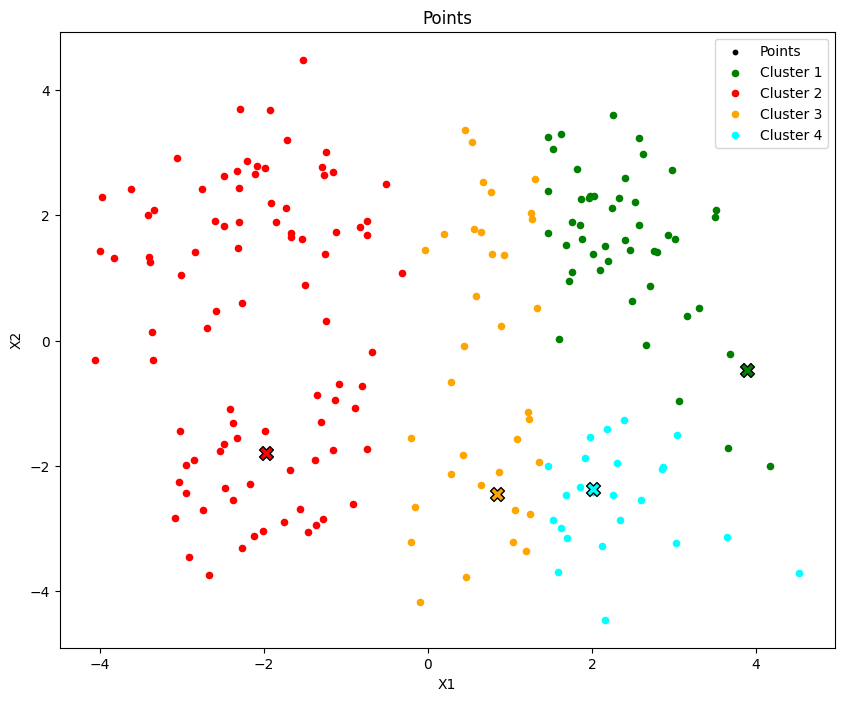

In [185]:
cl = find_nearest(X, C)
print(f"Total initial distance: {dist_tot(X, C, cl)}")
plot_clustering(X, C, cl, "Points", "X1", "X2")

In [186]:
print(f"Total initial distance: {dist_tot(X, C, cl)}")

Total initial distance: 590.1066884544713


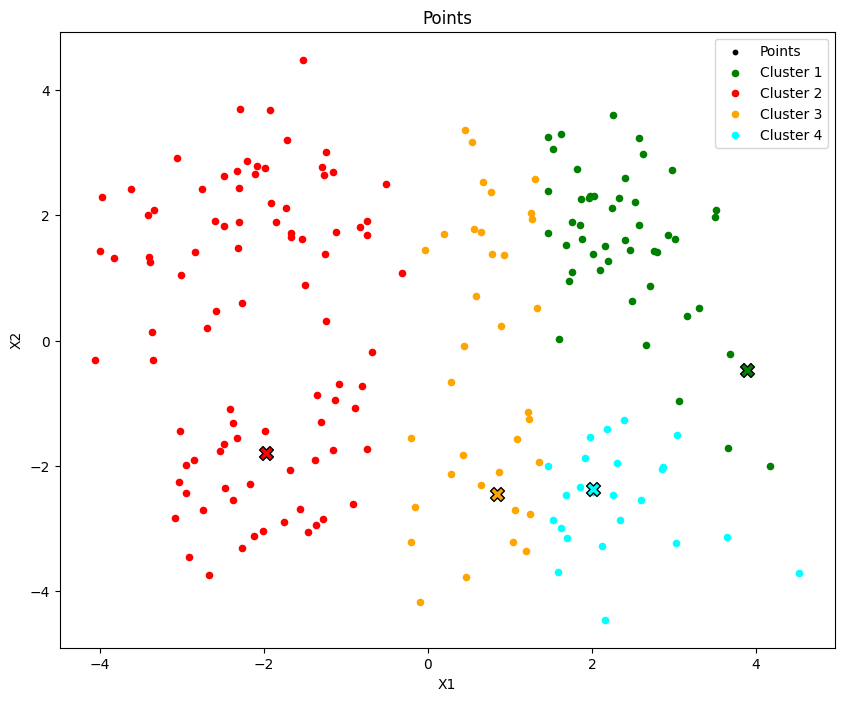

In [187]:
plot_clustering(X, C, cl, "Points", "X1", "X2")

# Part 3

## clu_algo function

In [188]:
def clu_algo(X, k, max_iter):
    """Performs the clustering algorithm similar to k-means but iterates to find cheaper configurations."""
    # initialize cluster centers randomly from X
    C = X[np.random.choice(X.shape[0], k, replace=False), :]
    best_cost = np.inf
    best_C = C
    best_clusters = {}

    # iteratively refine cluster centers
    for _ in range(max_iter):
        clusters = find_nearest(X, C)
        current_cost = dist_tot(X, C, clusters)
        cheaper = False
        
        # check each cluster and each point in X for a better cost
        for j in range(k):
            for i in range(X.shape[0]):
                temp_C = C.copy()
                temp_C[j, :] = X[i, :]  
                temp_clusters = find_nearest(X, temp_C)
                temp_cost = dist_tot(X, temp_C, temp_clusters)
                
                # update if a cheaper cost is found
                if temp_cost < best_cost:
                    best_cost = temp_cost
                    best_C = temp_C
                    best_clusters = temp_clusters
                    cheaper = True
        
        # if a cheaper cost is found, update C else break loop
        if cheaper:
            C = best_C
        else:
            break

    return {'C': best_C, 'clusters': best_clusters, 'cost': best_cost}

## Running clu_algo and Plotting Results

In [189]:
np.random.seed(4184)
n = 200
means = np.random.choice([-2, 2], n * 2, replace=True).reshape(n, 2)
X = np.random.normal(loc=means, scale=1, size=(n, 2))

In [190]:
result = clu_algo(X, 4, 50)
print("Cost at convergence:", result['cost'])

Cost at convergence: 301.02205983445185


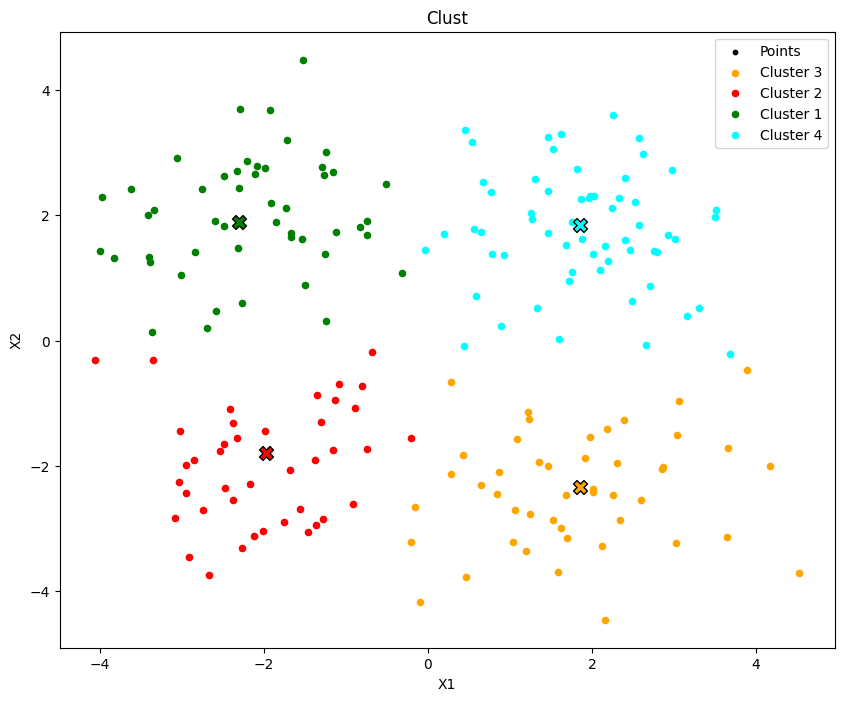

In [191]:
plot_clustering(X, np.array(result['C']), result['clusters'], "Clust", "X1", "X2")

# Part 4

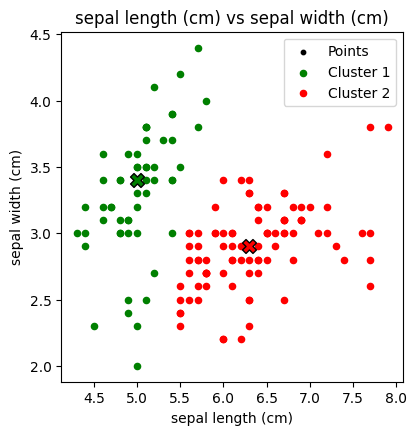

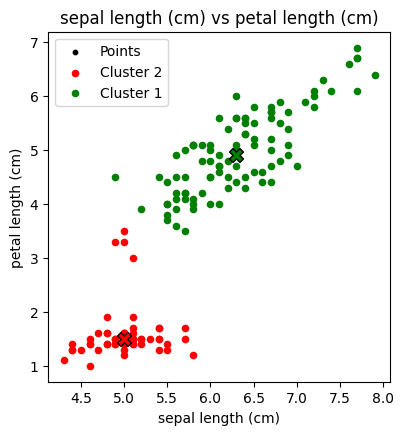

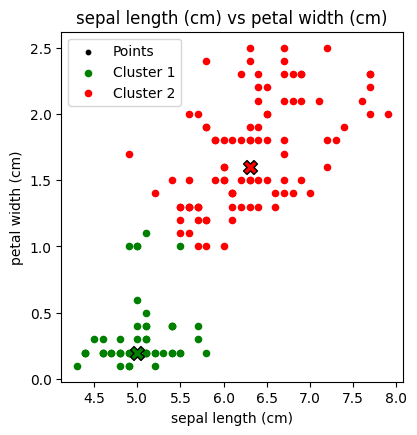

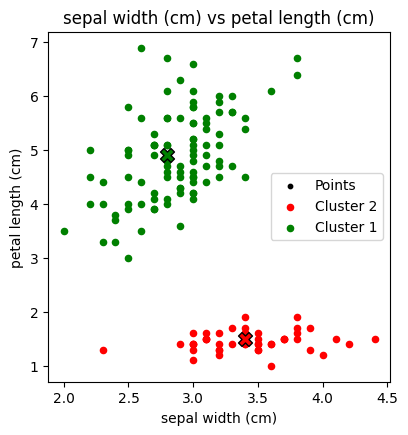

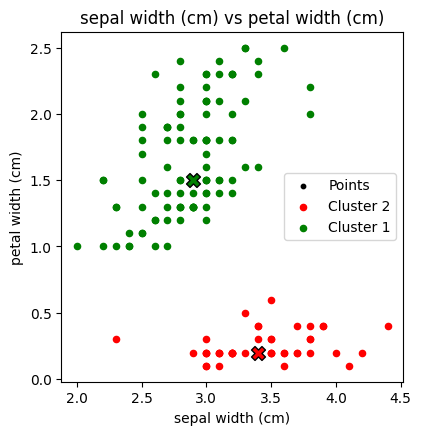

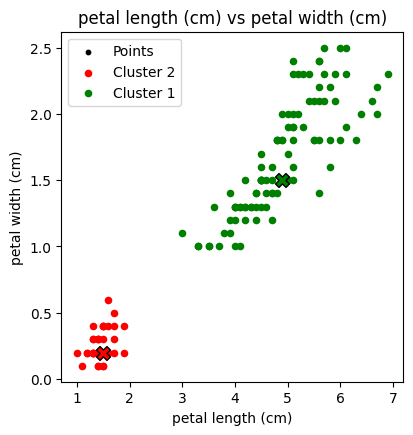

In [194]:
iris_data = iris.iloc[:, :4]

# get all combos pairs of cols 
pairs = list(combinations(range(iris_data.shape[1]), 2))

# create datasets for each combo pair 
datasets = [iris_data.iloc[:, list(pair)].values for pair in pairs]

# apply the clustering algorithm
clustering_results = [clu_algo(dataset, k=2, max_iter=50) for dataset in datasets]

# plotting
for i, result in enumerate(clustering_results):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, i + 1)
    dataset = datasets[i]
    C = np.array(result['C'])
    clusters = result['clusters']
    feature_names = iris_data.columns[list(pairs[i])]
    plot_clustering(dataset, C, clusters,
                    title=f"{feature_names[0]} vs {feature_names[1]}", xlab=feature_names[0], ylab=feature_names[1])

